In [346]:
# this is Saksham's file for ML models
import pandas as pd
import os
from typing import List, Optional, Dict
import gc
import matplotlib.pyplot as plt
import warnings
import numpy as np
from keras.callbacks import EarlyStopping
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from imblearn.over_sampling import SMOTE
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix, accuracy_score, f1_score
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.model_selection import train_test_split, KFold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
from tensorflow.keras.optimizers import Adam

warnings.filterwarnings("ignore")

def read_parquet(input_dir: str, years: Optional[List[int]] = None) -> Dict[int, pd.DataFrame]:
    """
    Reads Parquet files for specified years from the input directory.

    Args:
        input_dir (str): The directory where Parquet files are stored.
        years (Optional[List[int]]): A list of years to read. If None, read all available years.

    Returns:
        Dict[int, pd.DataFrame]: A dictionary with years as keys and pandas DataFrames as values.
    """
    data_frames = {}
    available_years = [int(d.split('=')[1]) for d in os.listdir(input_dir) if d.startswith('year=')]
    years_to_read = years if years is not None else available_years

    for year in years_to_read:
        year_path = os.path.join(input_dir, f'year={year}')
        if os.path.exists(year_path):
            df = pd.read_parquet(year_path)
            data_frames[year] = df
        else:
            print(f"Warning: No data found for year {year}")

    return data_frames



if __name__ == "__main__":
    years = [2015, 2016, 2017, 2018, 2019] 
    output_directory = "./data/DS/NSDUH"
    
    # Fetch and save dat
    # Initialize an empty DataFrame to hold all data
    df = pd.DataFrame()

    # Read saved data and concatenate into df
    for year in years:
        df_year = read_parquet(output_directory, [year])
        if year in df_year:
            # Concatenate the current year's DataFrame to df
            df = pd.concat([df, df_year[year]], ignore_index=True)

### Hypothesis: Subtle parent-child behaviors, though seemingly insignificant, may contribute to the development of depression

Getting our data. We have done this hypothesis before as well. Our output variable is YMDELT, that tells in binary (1,2) if kid is depressed. we change this mapping of 1,2 to 0,1.

Rest all are the Features that will be used to predict YMDELT = (MAJOR depressive episode)

1. "YEPCHKHW" : 'Check kid's Homework', 
2. "YEPHLPHW": 'Help kid with Homework', 
3. "YO_MDEA2" : 'Kid lost interst in playing and other things'
4. "YEPCHORE" : 'Make kids do House Chores', 
5. "YEPLMTTV" : 'Limit kid's TV', 
6. "YEPLMTSN" : 'Limit kid's Play time', 
7. "YO_MDEA1" : 'Kids feels Discouraged in doing task"
8. "YEPGDJOB" : 'parent say Good Job, when kid does a good job', 
9. "YEPPROUD" : 'Parent says they are Proud of kid', 
10. "YEYARGUP" : 'less Argue/Fight between parents and kid', 
11. "NEWRACE2" : 'Talk About bad effects of Drugs'

In [306]:
data_frame = df.copy()
data_behavourial = data_frame[
    (data_frame['YEPCHKHW'] >= 1) & (data_frame['YEPCHKHW'] <= 4) &
    (data_frame['YEPHLPHW'] >= 1) & (data_frame['YEPHLPHW'] <= 4) &
    (data_frame['YO_MDEA2'] >= 1) & (data_frame['YO_MDEA2'] <= 2) &
    (data_frame['YEPCHORE'] >= 1) & (data_frame['YEPCHORE'] <= 4) &
    (data_frame['YEPLMTTV'] >= 1) & (data_frame['YEPLMTTV'] <= 4) &
    (data_frame['YEPLMTSN'] >= 1) & (data_frame['YEPLMTSN'] <= 4) &
    (data_frame['YO_MDEA1'] >= 1) & (data_frame['YO_MDEA1'] <= 2) &
    (data_frame['YEPGDJOB'] >= 1) & (data_frame['YEPGDJOB'] <= 4) &
    (data_frame['YEPPROUD'] >= 1) & (data_frame['YEPPROUD'] <= 4) &
    (data_frame['YEYARGUP'] >= 1) & (data_frame['YEYARGUP'] <= 5) &
    (data_frame['NEWRACE2'] >= 1) & (data_frame['NEWRACE2'] <= 5) &
    (data_frame['YMDELT'] >= 1) & (data_frame['YMDELT'] <= 2) # THis is our Y or Output
]

### DATA CLEANING and preparation for ML models for prediction (OUTLIER Removal)

We Remove all the points or features whose compbinations have an average between 0.2 ro 0.8, these are outliers as they are not sure about to which class does the combination belongs and they cause unnecessary noise.

We then Scale the out features between 0 and 1. we have descrete features hence we can utilize minmax

In [307]:
result_data_behavourial = data_behavourial[['YEPCHKHW', 'YEPHLPHW', 'YEPCHORE', 'YEPLMTTV', 'YEPLMTSN', 'YEPGDJOB', 'YEPPROUD','YEYARGUP','NEWRACE2','YMDELT','YO_MDEA2','YO_MDEA1']]

result_data_behavourial['YMDELT'] = result_data_behavourial['YMDELT'].replace({1: 0, 2: 1})

features_to_normalize = [
    'YEPCHKHW', 'YEPHLPHW', 'YEPCHORE', 'YEPLMTTV',
    'YEPLMTSN', 'YEPGDJOB', 'YEPPROUD', 'YEYARGUP','NEWRACE2','YO_MDEA2','YO_MDEA1'
]

group_columns = result_data_behavourial.columns.difference(['YMDELT'])
#group_columns = result_data_behavourial.columns.difference(['YMDELT'])
grouped_stats = result_data_behavourial.groupby(list(group_columns))['YMDELT'].agg(['count', 'mean']).reset_index()
sorted_filtered_stats = grouped_stats.sort_values(by='count', ascending=False)

sorted_filtered_stats['output'] = np.where(
    sorted_filtered_stats['mean'] <= 0.2, 0,
    np.where(sorted_filtered_stats['mean'] >= 0.8, 1, np.nan)
)
cleaned_stats = sorted_filtered_stats.dropna(subset=['output'])

scaler = MinMaxScaler()
# Scaling out features between min and max

result_data_behavourial[features_to_normalize] = scaler.fit_transform(result_data_behavourial[features_to_normalize])

#### Balancing our dataset

As our dataset is Skewed, we need to add synthetic data to balance it. For that we use SMOTE.

It generates synthetic samples for the minority class to address the imbalance, this ensures that we have more balanced dataset for training the model.

SMOTE selects data point from the minority class and finds its nearest neighbors. Then, it creates new synthetic instances by interpolating between the selected data point and the neighbors, this increases minority data points.

In [324]:
result_data_behavourial = cleaned_stats[['YEPCHKHW', 'YEPHLPHW', 'YEPCHORE', 'YEPLMTTV', 'YEPLMTSN', 'YEPGDJOB', 'YEPPROUD', 'YEYARGUP', 'NEWRACE2', 'output','YO_MDEA2','YO_MDEA1']]

X = result_data_behavourial.drop(columns=['output']) # input variable: X
y = result_data_behavourial['output'] # output variable
smote = SMOTE(random_state=42)

X, y = smote.fit_resample(X, y)
# New X and y have original and synthetic data

### Dividing out dataset into Train and test dataset

We divide out dataset into training set and testing set. 

From the training and test set we take out small parameters called X_train, y_train and X_test and y_test, this data will be used to find best parameter fit for our models. According to the best fit we will train and test our data with large dataset.

X_train, y_train and X_test and y_test are small dataset for quick parameter finding, as it looks for best fit model using all models.

In [325]:
X_train_org, X_test_org, y_train_org, y_test_org = train_test_split(X, y, test_size=0.2, random_state=42)
print(len(X_train_org))
print(len(X_test_org))
X_train, _, y_train, _ = train_test_split(X_train_org, y_train_org, test_size=0.8,random_state=42)
X_test, _, y_test, _ = train_test_split(X_test_org, y_test_org, test_size=0.6, random_state=42)


9979
2495


### MODEL 1: KNN model

Why we want to select KNN model? 

From the phase 1 anaylsis we saw that for child depression the features were easily separable. Meaning for a depressed kid 90% parents did't ackowledge thier kids for their good work and for non depressed it was oppposite. so This shows that similar type of data remains on same side or are nearest to each other. 

Hence KNN makes sense here

#### Finding best K that will get us best prediction

The below code runs through 1 to 60 value of k to find the best fit

In [329]:
accuracy_list = []
k_values = range(1, 60)

for k in k_values:
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train, y_train)
    y_pred = knn.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    accuracy_list.append(accuracy)

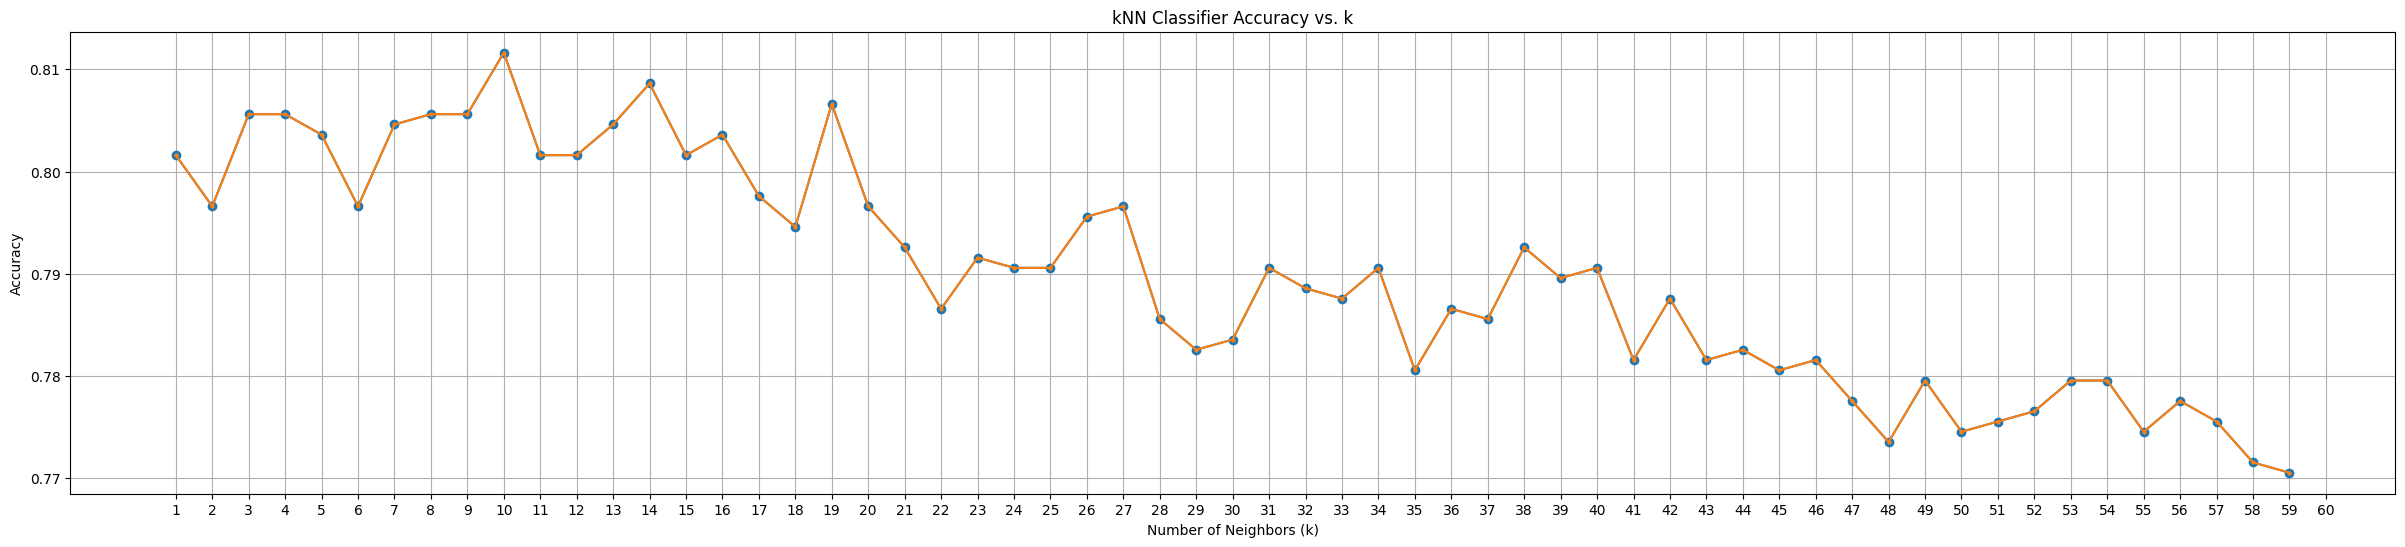

In [331]:
plt.figure(figsize=(30, 6))
plt.plot(k_values, accuracy_list, marker='o')
plt.title('kNN Classifier Accuracy vs. k')
plt.xlabel('Number of Neighbors (k)')
plt.ylabel('Accuracy')
plt.plot(k_values, accuracy_list, marker='o', markersize=2)
plt.xticks(np.arange(1, 61, 1))  # Set x-ticks for every integer k
plt.grid()
plt.show()

The above graph shows performcne of Knn on our data with different value of K.
The Above graph shows that bigger value of K gives worse performance and at *10* it gives the best performance.

KNN best fit is K = 10

##### Training KNN with value of K as 10 on our data

Model Accuracy: 86.2525050
F1 Score: 0.8624966


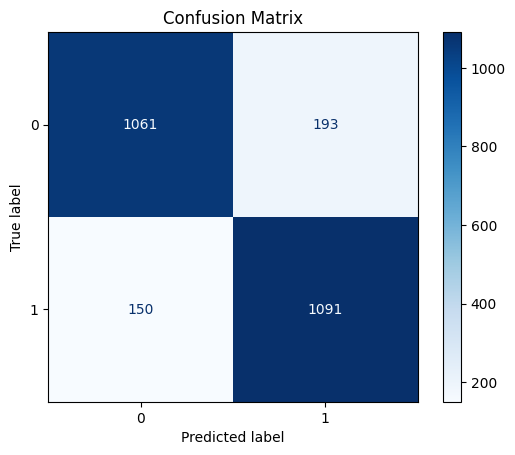

In [333]:

knn = KNeighborsClassifier(n_neighbors=10)
knn.fit(X_train_org, y_train_org)

y_pred = knn.predict(X_test_org)

accuracy = accuracy_score(y_test_org, y_pred)
f1 = f1_score(y_test_org, y_pred, average='weighted')

print(f"Model Accuracy: {accuracy*100:.7f}")
print(f"F1 Score: {f1:.7f}")

conf_matrix = confusion_matrix(y_test_org, y_pred)

disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix)
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()

##### We can see that KNN gives us 86.25% prediction on our data. 

Knn giving us this much prediction means that data is somewhat separable and we need to use some algorithm that utilizes this sepration well and is easy to use.

### MODEL 2: Random Forest

We can use Random forest as our data set is little complex and somewhat seprable as we got it from K-NN. We also want our machine to be robust to any outlier and noise as chances of outlier still exist even after out cleaning. 

##### We find parameters for our random forest, these parameters are number of trees and and maximum depth of each tree

In [334]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report

n_estimators_range = range(1, 101)  # 1 to 100
max_depth_range = range(1, 21)      # 1 to 20

accuracy_scores = np.zeros((len(n_estimators_range), len(max_depth_range)))

for i, n_estimators in enumerate(n_estimators_range):
    for j, max_depth in enumerate(max_depth_range):
        rf_model = RandomForestClassifier(n_estimators=n_estimators, max_depth=max_depth, random_state=42)
        rf_model.fit(X_train_org, y_train_org)
        y_pred = rf_model.predict(X_test_org)
        accuracy_scores[i, j] = accuracy_score(y_test_org, y_pred)


In [339]:
import plotly.express as px

n_estimators_vals, max_depth_vals = np.meshgrid(n_estimators_range, max_depth_range, indexing='ij')
n_estimators_list = list(range(1, 101))
max_depth_list = list(range(1, 21))

plot_data = pd.DataFrame(accuracy_scores, index=n_estimators_list, columns=max_depth_list)

fig = px.imshow(plot_data, 
                labels=dict(x="max_depth", y="n_estimators", color="Accuracy"),
                x=max_depth_list, y=n_estimators_list, aspect="auto")
fig.update_layout(title="Interactive Heatmap of Accuracy for Different n_estimators and max_depth")
fig.show()


The above heat maps helps us selecting best max depth and maximum number of tress and from the graph we can see that tree number = 1, which is effectivly a decision tree have very bad accuracy. Hence a random forest is a better choice than selecting a decision tree.

From the heat map we can see that with increase in depth the accuracy increased and even with increase in number of trees the accuracy increased. We need to find the point with maximum accuracy.

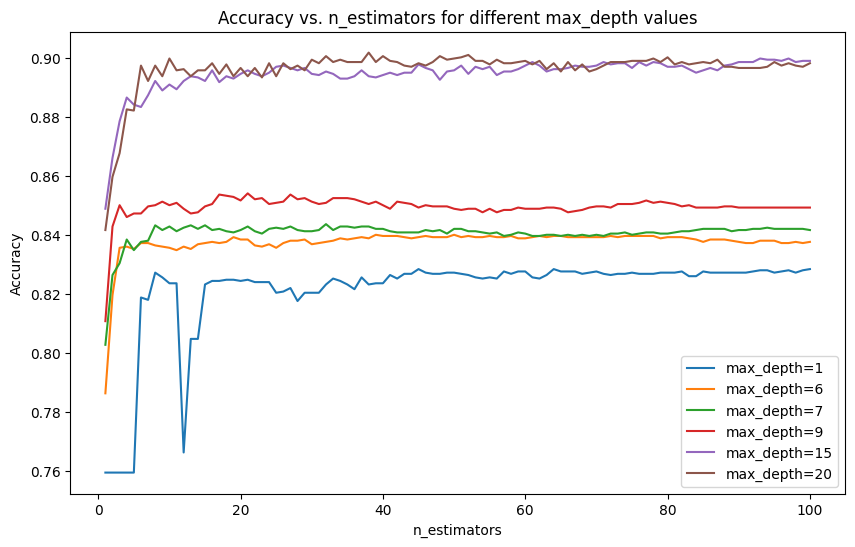

In [340]:
plt.figure(figsize=(10, 6))
for max_depth in [1, 6, 7, 9, 15, 20]:
    accuracies = [accuracy_scores[i, max_depth-1] for i in range(len(n_estimators_range))]
    plt.plot(n_estimators_range, accuracies, label=f'max_depth={max_depth}')

plt.xlabel('n_estimators')
plt.ylabel('Accuracy')
plt.title('Accuracy vs. n_estimators for different max_depth values')
plt.legend()
plt.show()

##### The above graph shows accuracy of our model with respect to number of trees and max depth of the tree. We can see higher max depth tree shows better result

In [341]:
import numpy as np
import pandas as pd

num_n_estimators, num_max_depth = accuracy_scores.shape

flat_indices = np.argsort(accuracy_scores, axis=None)[-40:]

top_scores = []
for idx in flat_indices:
    i = idx // num_max_depth  
    j = idx % num_max_depth  
    top_scores.append((accuracy_scores[i, j], i + 1, j + 1)) 

top_scores_df = pd.DataFrame(top_scores, columns=["Accuracy", "n_estimators", "max_depth"])

print(top_scores_df.sort_values(by="Accuracy", ascending=False).head(3))

    Accuracy  n_estimators  max_depth
39  0.903407            30         17
38  0.901804            38         20
37  0.901403            44         16


##### The best fit is n_estimators = 30 and max_depth = 17

Model Accuracy: 90.34%
              precision    recall  f1-score   support

         0.0       0.92      0.88      0.90      1254
         1.0       0.89      0.92      0.90      1241

    accuracy                           0.90      2495
   macro avg       0.90      0.90      0.90      2495
weighted avg       0.90      0.90      0.90      2495

Confusion Matrix:


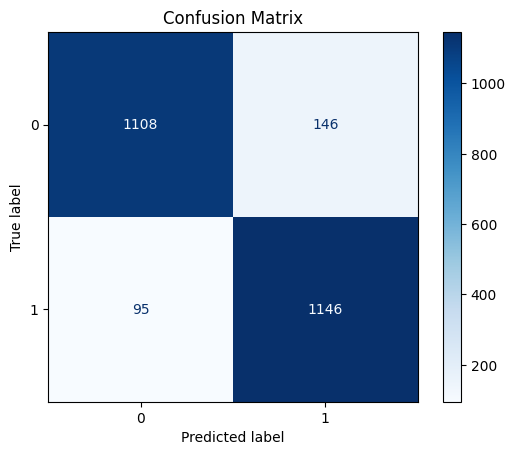

In [345]:
from sklearn.metrics import classification_report
rf_model = RandomForestClassifier(n_estimators=30, max_depth=17, random_state=42)
rf_model.fit(X_train_org, y_train_org)
y_pred = rf_model.predict(X_test_org)
accuracy = accuracy_score(y_test_org, y_pred)
print(f"Model Accuracy: {accuracy*100:.2f}%")
report = classification_report(y_test_org, y_pred)
print(report)

conf_matrix = confusion_matrix(y_test_org, y_pred)
print("Confusion Matrix:")
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix)
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()

#### With Random forest we got accuracy of 90.34%, which is quite better than Knn. 

Random forest is good in handling complex data, handling outliers, noise and large dataset, whereas knn is simple distance based approach, we can't expect much from knn when data has complex relationship with output. Additionally k-NN can be sensitive to outliers because it relies on the neighbouring data points.

Because of the above factor random forest worked well on our data



In [347]:
def build_model(lambda_val):
    model = tf.keras.Sequential([
             tf.keras.layers.Dense(1, activation='sigmoid')
    ])
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

def build_deepmodel(lambda_val):
    model = tf.keras.Sequential([
        tf.keras.layers.Dense(8, activation='tanh', kernel_regularizer=tf.keras.regularizers.l2(lambda_val), input_shape=(X_train.shape[1],)),
        tf.keras.layers.Dense(15, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(lambda_val), input_shape=(X_train.shape[1],)),
        tf.keras.layers.Dense(15, activation='tanh', kernel_regularizer=tf.keras.regularizers.l2(lambda_val), input_shape=(X_train.shape[1],)),
        tf.keras.layers.Dense(1, activation='sigmoid')  # Assuming binary classification
    ])
    #optimizer = Adam(learning_rate=0.0001)
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

from the above grph we now know this that all the parameters are independent, 
as if it was not eror would be

In [320]:
early_stopping = EarlyStopping(
    monitor='accuracy',  # Metric to monitor
    patience=700,         # Number of epochs with no improvement after which training will be stopped
    verbose=0          # Verbosity mode (0 = silent, 1 = messages)
)
lambda_values = np.arange(0, 1.1, 0.1)
best_lambda = 0
best_score = 0
lambda_value_list = list()
for lambda_val in lambda_values:
    # Build model with the current lambda value
    model = build_deepmodel(lambda_val)
    
    # Train the model on the entire training dataset
    model.fit(X_train, y_train, epochs=20000, batch_size=20000, verbose=0, callbacks=[early_stopping])
    
    # Evaluate the model on the entire training dataset
    val_loss, val_accuracy = model.evaluate(X_test, y_test, verbose=0)

    # Output the accuracy
    print(f"Lambda: {lambda_val}, Accuracy on test Dataset: {val_accuracy}")
    lambda_value_list.append(val_accuracy)
    # Check if this is the best score
    if val_accuracy > best_score:
        best_score = val_accuracy
        best_lambda = lambda_val

print(f"Best Lambda: {best_lambda} with Accuracy: {best_score}")

Lambda: 0.0, Accuracy on test Dataset: 0.8016031980514526
Lambda: 0.1, Accuracy on test Dataset: 0.796593189239502
Lambda: 0.2, Accuracy on test Dataset: 0.4989979863166809
Lambda: 0.30000000000000004, Accuracy on test Dataset: 0.4989979863166809
Lambda: 0.4, Accuracy on test Dataset: 0.4989979863166809
Lambda: 0.5, Accuracy on test Dataset: 0.4989979863166809
Lambda: 0.6000000000000001, Accuracy on test Dataset: 0.4989979863166809
Lambda: 0.7000000000000001, Accuracy on test Dataset: 0.4989979863166809
Lambda: 0.8, Accuracy on test Dataset: 0.4989979863166809
Lambda: 0.9, Accuracy on test Dataset: 0.4989979863166809
Lambda: 1.0, Accuracy on test Dataset: 0.4989979863166809
Best Lambda: 0.0 with Accuracy: 0.8016031980514526


we have realized that it's model won't overfit because of which lamda 0 and other lambda values comes as same. and a simple perceptron gives almost same accuracy as perceptron. SO let's make our model based on perceptron 

In [322]:
import numpy as np
from keras.callbacks import EarlyStopping
from keras.models import load_model
# Define lambda values to test
early_stopping = EarlyStopping(
    monitor='accuracy',  # Metric to monitor
    patience=700,         # Number of epochs with no improvement after which training will be stopped
    verbose=0          # Verbosity mode (0 = silent, 1 = messages)
)

    # Build model with the current lambda value
model = build_model(0)
    
    # Train the model on the entire training dataset
model.fit(X_train_org, y_train_org, epochs=10000, batch_size=20000, verbose=1, callbacks=[early_stopping])
    
    # Evaluate the model on the entire training dataset
val_loss, val_accuracy = model.evaluate(X_test_org, y_test_org, verbose=0)
print(f"Lambda: {0}, Accuracy on Entire Dataset: {val_accuracy}")

Epoch 1/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 195ms/step - accuracy: 0.4997 - loss: 2.1996
Epoch 2/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.4999 - loss: 2.1892
Epoch 3/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.4997 - loss: 2.1787
Epoch 4/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.4996 - loss: 2.1682
Epoch 5/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.4996 - loss: 2.1578
Epoch 6/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.4994 - loss: 2.1474
Epoch 7/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.4994 - loss: 2.1370
Epoch 8/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.4993 - loss: 2.1266
Epoch 9/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.4995 - loss: 2.1162
Epoch 10/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.5005 - loss: 2.1058
Epoch 11/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.5006 - loss: 2.0955
Epoch 12/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step

### Observation

| Model            | Accuracy |
|------------------|----------|
| Deep Neural Net  | ~84%      |
| k-NN             | ~86%      |
| Random Forest    | 90.4%    |

Choosing Random Forest because

1. Better Generalization: With an accuracy of 90.4%, it outperformed k-NN (~86%) and Deep Neural Networks (~84%), demonstrating better generalization on unseen data.

2. Handling Non-Linearity: Random Forest can model complex, non-linear interactions between features, which is beneficial for capturing relationships that k-NN and Linear Regression may miss.

3. Robust to Noise: It is less sensitive to outliers and noise compared to k-NN, making it a more stable choice for real-world data.

4. Efficient Performance: It delivers high accuracy with minimal tuning compared to Deep Neural Networks, which are computationally expensive for this problem.

5. Although KNN is easy to use but slows down significantly for when data is large. 

6. Deep neural net that we have used is complex but still we are not able to generalize our data. Training it takes a lot of time, making it computationally expensive, Additionally finding how many hidden layers required is a diffifult task.  7. 

7. Randomforest was fast in learning data and it can predict data quickly as well with highest accuracy on our dataset.

Note: It's always advised to use simplest model and in our case random forest is the simplest model with the highest accuracy. 